In [1]:
%load_ext autoreload
%autoreload 2

# Adaptation metric look #2

In [2]:
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
import os
import sys
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


jax.config.update('jax_platform_name', 'cpu')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1



[CpuDevice(id=0)]

Text(0.5, 1.0, 'But some "high" adaptations (minimum of the\nbinary region) are not actually\nadaptable (green points outside boundary)')

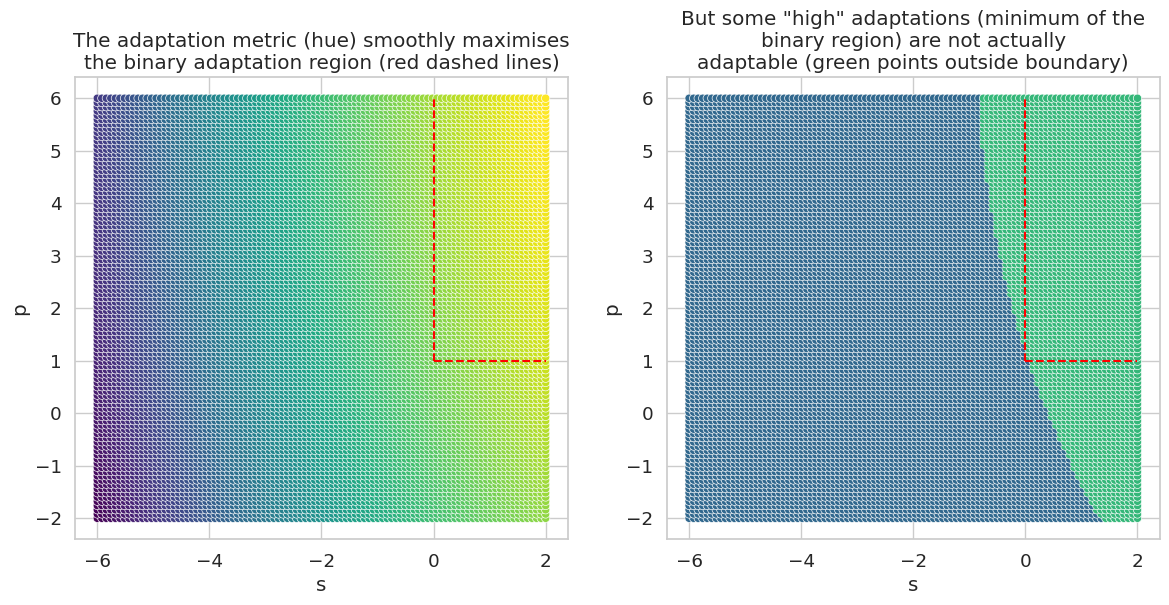

In [34]:
# Define ranges for variables 's' and 'p'
n_points = 100
s_values = np.linspace(-6, 2, n_points)
p_values = np.linspace(-2, 6, n_points)

# Create a meshgrid for plotting
S, P = np.meshgrid(s_values, p_values)

# Calculate adaptation metric 'a' for each (s, p) pair
A = calculate_adaptation(np.power(10, S), np.power(10, P))

df_s = pd.DataFrame({'s': S.flatten(), 'p': P.flatten(), 'a': A.flatten()})
df_s['Adaptable'] = (df_s['s'] >= 0) & (df_s['p'] >= 1)
df_s['Pseudo_adaptable'] = df_s['a'] >= df_s[df_s['Adaptable']]['a'].min()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=df_s,
                x='s', y='p', hue='a', palette='viridis', legend=False, ax=axs[0])
axs[0].vlines(0, 1, 6, colors='red', linestyles='dashed')
axs[0].hlines(1, 0, 2, colors='red', linestyles='dashed')
axs[0].set_title('The adaptation metric (hue) smoothly maximises\nthe binary adaptation region (red dashed lines)')

sns.scatterplot(data=df_s,
                x='s', y='p', hue='Pseudo_adaptable', palette='viridis', legend=False, ax=axs[1])
axs[1].vlines(0, 1, 6, colors='red', linestyles='dashed')
axs[1].hlines(1, 0, 2, colors='red', linestyles='dashed')
axs[1].set_title('But some "high" adaptations (minimum of the\nbinary region) are not actually\nadaptable (green points outside boundary)')

